# EJERCICIO 2
# Clasificación de Imágenes

## Librerías

In [1]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from random import sample
from random import shuffle
from math import ceil as techo
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score 
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, RepeatedKFold, StratifiedShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier

## Funciones

In [2]:
def CargaDatos(rutaObjects,verbose=False):
    def ordenaDirectorio(directorio, extension="jpg"):
        return sorted([os.path.join(directorio, f) for f in os.listdir(directorio) if f.endswith(extension)])
    animales = ['elephant', 'emu', 'flamingo', 'rhino']
    
    datos = {}
    for animal in animales:
        datos[animal] = ordenaDirectorio(f"{rutaObjects}/images/{animal}", extension="jpg"), ordenaDirectorio(f"{rutaObjects}/masks/{animal}", extension="png")

    print('Cargando datos...')
    if verbose:
        for animal in datos:
            print(f'\nAnimal: {animal}')
            for imagen, mascara in zip(datos[animal][0], datos[animal][1]):
                print(f"Imagen: {os.path.basename(imagen)}, Máscara: {os.path.basename(mascara)}")
    return datos
#####################
def recortadoAleatorio(pixeles, minimo):
    indices = sorted(sample(range(len(pixeles)),minimo))
    return np.array([pixeles[indice] for indice in indices]).flatten()
####################
def desordena(X,Y):
    temp = list(zip(X, Y))
    shuffle(temp)
    return zip(*temp)
    

#########################
def procesaImagen(imagen, mascara,numPixeles,padin,pixeliza):
    
    def haz_histograma(pixeles):
        return np.array([np.histogram(pixelesEnMascara[:,color],bins=np.arange(256))[0] for color in range(3)]).flatten(order='F')
    
    def MascaraGaussianoSobel(imagen,mascara,padin,pixeliza):
        if padin:
            imagen = imagen[padin:-padin,padin:-padin] 
            imagen = np.reshape([imagen[i][j] * mascara[i][j] for i in range(tamano[0]-padin*2) for j in range(tamano[1]-padin*2)],(tamano[0]-padin*2,tamano[1]-padin*2,3))
            imagen = cv2.GaussianBlur(imagen, (0, 0), 2, 2)
            imagen = cv2.Sobel(imagen, -1,1,0,ksize=3).flatten() 
            return  cv2.resize(cv2.Sobel(imagen, -1,1,0,ksize=3), (int(tamano[1]*pixeliza),int(tamano[0]*pixeliza))).flatten() 


        imagen = np.reshape([imagen[i][j] * mascara[i][j] for i in range(tamano[0]) for j in range(tamano[1])],(tamano[0],tamano[1],3))
        imagen = cv2.GaussianBlur(imagen, (0, 0), 2, 2)
        imagen = cv2.Sobel(imagen, -1,1,0,ksize=3).flatten() 
        return  cv2.resize(cv2.Sobel(imagen, -1,1,0,ksize=3), (int(tamano[1]*pixeliza),int(tamano[0]*pixeliza))).flatten() 

    
    
    imagen = cv2.imread(imagen)
    imagen = cv2.resize(imagen, (tamano[1],tamano[0])) # si lo pongo tal cual y luego hago imagen.shape devuelve (300, 200)

    mascara = cv2.imread(mascara, cv2.IMREAD_GRAYSCALE)
    mascara = cv2.resize(mascara, (tamano[1],tamano[0]))
        
    mascaraBinaria = mascara = (mascara > 0).astype(bool)  # Binarizar la máscara
    
    #imagen = cv2.Sobel(imagen, -1,1,0,ksize=3)    MALOS RESULTADOS   
    #imagen = cv2.GaussianBlur(255 - imagen, (0, 0), 2, 2)
    
    pixelesEnMascara = np.reshape(np.array([np.array(imagen[i][j]) for i in range(tamano[0]) for j in range(tamano[1]) if mascaraBinaria[i][j]]),(sum(sum(mascaraBinaria)),3))
    histograma = haz_histograma(pixelesEnMascara)
    algunosPixeles = recortadoAleatorio(pixelesEnMascara,numPixeles)
   
    if numPixeles:
        return [*histograma, *algunosPixeles, *MascaraGaussianoSobel(imagen,mascara,padin,pixeliza)]
    else:
        return [*histograma]
###########################
def construyeDataset(datos,numPixeles,padin,pixeliza,balancear=True):
    
    X = []
    Y = []
    factorMultiplicativo = 1

    print('Procesando datos...')
    for i in range(factorMultiplicativo):
        for animal in datos:
            print(f'\nAnimal: {animal}')
            for imagen, mascara in zip(datos[animal][0], datos[animal][1]):
                # Cargar y redimensionar imagen
                
                X.append(procesaImagen(imagen, mascara,numPixeles,padin,pixeliza))

                if animal == 'elephant':
                    Y.append('E')
                elif animal == 'rhino':
                    Y.append('R')
                else:
                    Y.append('O') # la O de Otros
    
    X = np.array(X)

    if balancear:
        X = list(X)
        Y = list(Y)
        nummin = min(Y.count('R'), Y.count('E'), Y.count('O'))
        contador = {'R': 0, 'E': 0, 'O': 0}
        for i, clase in reversed(list(enumerate(Y))): # lo hago de atras hacia delante porque si borro por ejemplo el indice 127 luego al borrar el indice, por ejemplo, 233, reamente estoy borrando el 234
            contador[clase] += 1
            #print(i,clase,nummin, contador[clase])
            if contador[clase] > nummin:
                 #print('X')
                 del X[i], Y[i]   
    return X, Y

def separaEntrenamientoTest(X,Y, razon=0.8,unoFuera=False):
    X, Y = desordena(X, Y)
    
    if unoFuera:
        X_entrenamiento = X[:-2]
        X_test =          np.array(X[-1]).reshape(1, -1)
        Y_entrenamiento = Y[:-2]
        Y_test =          np.array(Y[-1]).reshape(1, -1)
        return X_entrenamiento, Y_entrenamiento, X_test, Y_test
    
    X_entrenamiento = X[:techo(len(X)*razon) ]
    X_test =          X[ techo(len(X)*razon):]
    Y_entrenamiento = Y[:techo(len(X)*razon) ]
    Y_test =          Y[ techo(len(X)*razon):]
    return X_entrenamiento, Y_entrenamiento, X_test, Y_test

## Código Principal

In [3]:
tamano = (200, 300)
datos = CargaDatos('../objects')
X, Y = construyeDataset(datos,numPixeles=1500, padin=0, pixeliza=1, balancear=True)

Cargando datos...
Procesando datos...

Animal: elephant

Animal: emu

Animal: flamingo

Animal: rhino


## Validación cruzada

In [4]:
acuracis = []
N = 15
for i in range(N):
    
    
    X_entrenamiento, Y_entrenamiento, X_test, Y_test = separaEntrenamientoTest(X,Y,razon=0.9)
    #X_entrenamiento, Y_entrenamiento, X_test, Y_test = separaEntrenamientoTest(X,Y,unoFuera=True)
    
    modelo_svm = svm.SVC(kernel='rbf')
    modelo_svm.fit(X_entrenamiento,Y_entrenamiento)
    Y_predicho = modelo_svm.predict(X_test)
    
    acuracis.append(accuracy_score(Y_test,Y_predicho))

Acuracy de 0.64 ± 0.14. Se usaron 15 intentos.


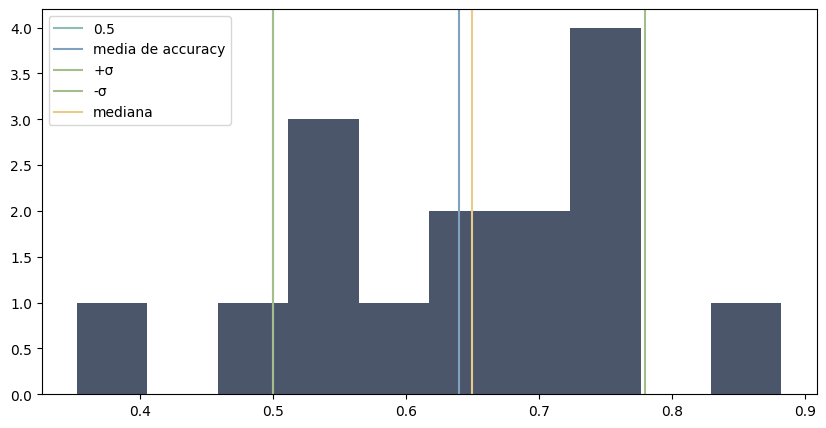

In [5]:
media = round(np.mean(acuracis),2)
sigma = round(np.sqrt(np.var(acuracis)),2)
mediana = round(np.median(acuracis),2)

plt.figure(figsize = (10, 5))
plt.axvline(x = .5, color = '#8fbcbb',label='0.5')
plt.axvline(x = media, color = '#81a1c1',label='media de accuracy')
plt.axvline(x = media + sigma , color = '#a3be8c',label='+σ')
plt.axvline(x = media - sigma, color = '#a3be8c',label='-σ')
plt.axvline(x = mediana, color = '#ebcb8b',label='mediana')

plt.hist(acuracis,color='#4c566a',bins=10)
plt.legend()

print(f'Acuracy de {media} ± {sigma}. Se usaron {N} intentos.')